## This notebook is for creating and testing different models on classifying a salary range for a job posting

In [55]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# !jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable widgetsnbextension --user --py --sys-prefix
# Catboost widgets do not seem to work on my vscode notebooks.




The system cannot find the path specified.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [26]:
df = pd.read_csv(os.path.dirname(os.getcwd())+"\\EDA\\clean_data.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,new_title,min_salary,max_salary,loc_state
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K,Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),Analyst Remote,37.0,66.0,NY
1,1,Quality Data Analyst,$37K-$66K,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),Data Analyst,37.0,66.0,NY
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K,We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,Analytics Solutions,37.0,66.0,NY
3,3,Data Analyst,$37K-$66K,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),Data Analyst,37.0,66.0,NY
4,5,Data Analyst,$37K-$66K,About Cubist\nCubist Systematic Strategies is ...,3.9,Point72,"New York, NY","Stamford, CT",1001 to 5000 employees,Company - Private,Investment Banking & Asset Management,Finance,Unknown / Non-Applicable,Data Analyst,37.0,66.0,NY


In [27]:
cols_to_keep = ["Rating",'Size','Type of ownership','Industry','Sector','Revenue','new_title','loc_state']
# for now, drop all na values
X = df[cols_to_keep]
y = pd.cut(df["min_salary"],bins=[0,50,70,max(df['min_salary'])],labels=["Low","Average","High"])

y.value_counts()

Low        967
Average    595
High       360
Name: min_salary, dtype: int64

In [28]:
X.dtypes

Rating               float64
Size                  object
Type of ownership     object
Industry              object
Sector                object
Revenue               object
new_title             object
loc_state             object
dtype: object

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Train + val & test

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]
cat_idx = [X.columns.get_loc(col) for col in categorical_features]


# columnTransformer = ColumnTransformer(
#     transformers=[
#         ('cat', OrdinalEncoder(), categorical_features)])

# X_train = columnTransformer.fit_transform(X_train)
# X_test = columnTransformer.fit_transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42) # Train & val



In [45]:
params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'eval_metric': metrics.AUCMulticlass(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 4
}
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
validate_pool = Pool(X_val, y_val, cat_features=cat_idx)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool,plot=True)

print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_test, model.predict(X_test))
))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Simple model validation accuracy: 0.5662


### Huge overfitting issue here

### Drop unimportant categories

In [32]:
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

loc_state: 86.74640546337781
Rating: 6.194821811501914
Size: 5.050158905692258
new_title: 1.3827179073830527
Revenue: 0.6258959120449656
Type of ownership: 0.0
Sector: 0.0
Industry: 0.0


### It is no surprise that the state, rating and the size of the company affect the minimum salary significantly. Though, what is quite surprising is that the sector and industry do not have any importance in our model. This could be due to execcise missing values, or just due to the datasets underlying structure. I would have quessed that the industry that you are working in would impact on the salary. Either way, lets us drop the features that have no importance at all

In [70]:
params = {
    'iterations': 300,
    'learning_rate': 0.05,
    # 'custom_metric': metrics.Precision(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'od_type': 'Iter',
    'od_wait': 10
}
rm_cols = ['Type of ownership','Sector','Industry']
rm_cols = ['Type of ownership','Industry','Sector','Revenue']
X_train_new = X_train.drop(columns=rm_cols)
X_val_new = X_val.drop(columns=rm_cols)
X_test_new = X_test.drop(columns=rm_cols)

numeric_features = X_train_new.select_dtypes(include=np.number).columns.tolist()
categorical_features = [c for c in X_train_new.columns if c not in numeric_features]
cat_idx_new = [X_train_new.columns.get_loc(col) for col in categorical_features]

train_pool = Pool(X_train_new, y_train, cat_features=cat_idx_new)
validate_pool = Pool(X_val_new, y_val, cat_features=cat_idx_new)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool,plot=True)

y_pred = model.predict(X_test_new)
print('Simple model test accuracy: {:.4}'.format(
    accuracy_score(y_test, y_pred)
))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Simple model test accuracy: 0.5896


Text(33.0, 0.5, 'Real')

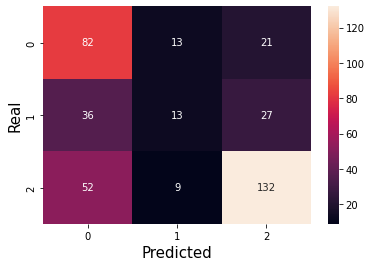

In [71]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d")
plt.xlabel('Predicted', fontsize = 15)
plt.ylabel('Real', fontsize = 15)

In [52]:
y_test.value_counts()

Low        193
Average    116
High        76
Name: min_salary, dtype: int64